In [1]:
vlib =  c("tidyverse", "ggpubr", "survminer", "survival", "broom", "ggsci", "patchwork", "doFuture", "foreach", "maxstat", "viridis")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |> suppressMessages()

base_dir = "."
setwd(base_dir)

saveRDS.gz <- function(object, file, threads = 4) {
  con <- pipe(paste0("pigz -p", threads, " > ", file), "wb")
  saveRDS(object, file = con)
  close(con)
}
readRDS.gz <- function(file, threads = parallel::detectCores()) {
  con <- pipe(paste0("pigz -d -c -p", threads, " ", file))
  object <- readRDS(file = con)
  close(con)
  return(object)
}

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [2]:
df_surv = read_delim("assets/wgcna/survdata_temp.txt")
df_map_cis = read_delim("assets/02_mashr/joined_all_results.txt.gz")
df_surv %>% distinct(regimen)

Rows: 73 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): ID, CD8_brown_binary_ratio, CD8_TEM_binary_ratio, histology, PDL1_...
dbl (14): PFS, OS, PFS_CENSOR, OS_CENSOR, CD8_brown_High, CD8_brown_Low, CD8...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 69897 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): phenotype_id, variant_id, condition, prefix_file, name
dbl (10): lfsr, PosteriorMean, PosteriorSD, start_distance, af, ma_samples, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


regimen
<chr>
Pembrolizumab
Atezolizumab
Nivolumab


In [3]:
c_name = "CD8"
c_prefix = "/data/nfs_dell/project_HS/202310-sceqtl_v6/"
fname_modulescore = paste0(c_prefix, "scRNA_wgcna_pipeline/gene_score_UCell_25/", c_name, ".coregenes.txt.gz")
fname_md = paste0(c_prefix, "scRNA_wgcna_pipeline/gene_expression/md.txt.gz")
#fname_modulescore = paste0("scRNA_wgcna_pipeline/hME_cell_metric/", c_name, ".txt.gz")
df_modulescore = read_delim(fname_modulescore)
df_md = read_delim(fname_md)
#df_modulescore$CellID= df_md$CellID

Rows: 559714 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): CellID, orig.ident, sample, time, sample_time, file, anno_l2, anno...
dbl (15): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, leiden, Sex, A...
lgl  (4): CHIP_BEFORE_SEVERE, CHIP_BEFORE_BINARY, CHIP_AFTER_SEVERE, CHIP_AF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 559714 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (17): CellID, orig.ident, sample, time, sample_time, file, anno_l2, anno...
dbl (16): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, leiden, Sex, A...
lgl  (4): CHIP_BEFORE_SEVERE, CHIP_BEFORE_BINARY, CHIP_AFTER_SEVERE, CHIP_AF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [4]:
df_hME = read_delim(paste0(c_prefix, "scRNA_wgcna_pipeline/hME_cell_metric/", c_name, ".txt.gz"))
df_hME$CellID= df_md$CellID

Rows: 559714 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (12): black, magenta, brown, red, yellow, turquoise, green, pink, greeny...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Joining with `by = join_by(CellID)`


Joining with `by = join_by(CellID, sample)`


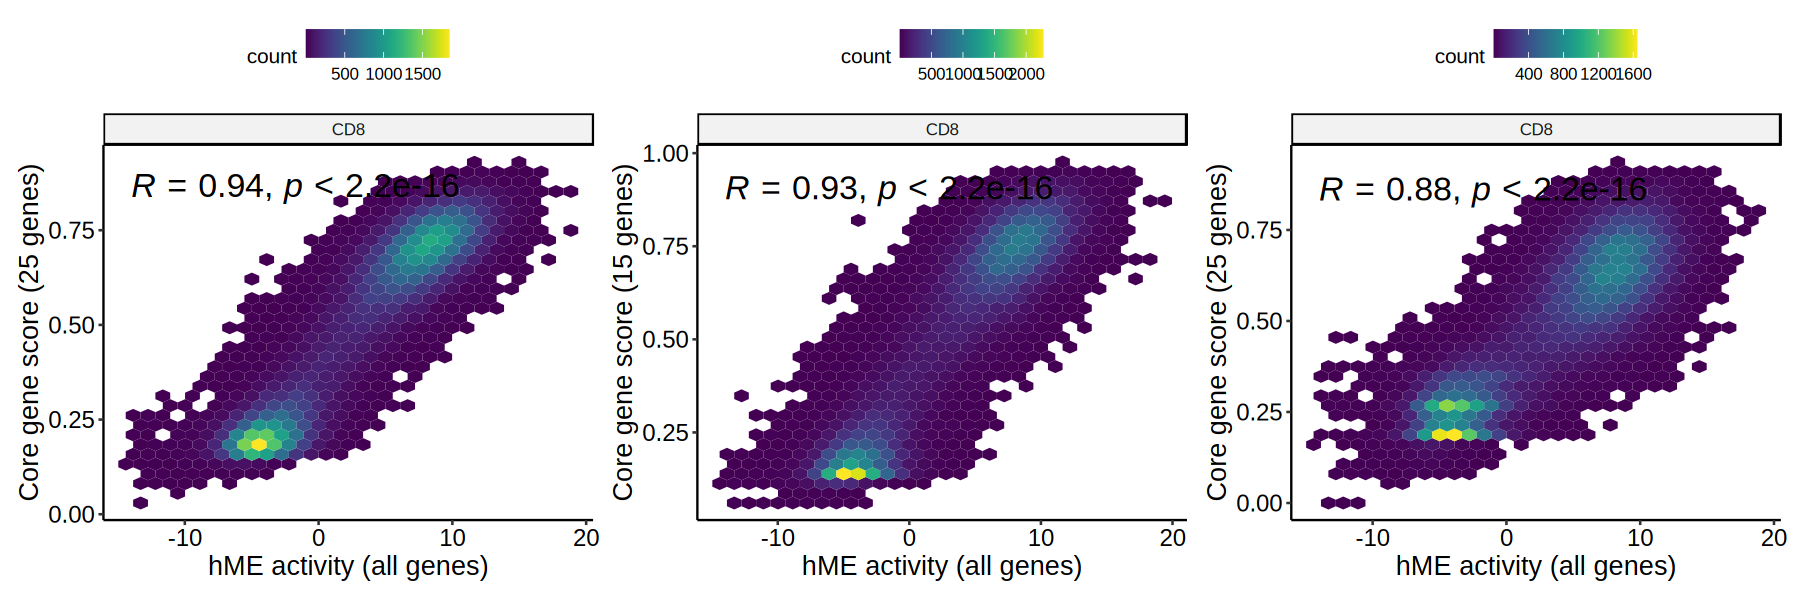

In [5]:
options(repr.plot.width = 15, repr.plot.height =5 )
df_corr = df_hME %>% select(brown, CellID) %>% 
  dplyr::rename(hME_brown = brown) %>% 
  left_join(df_modulescore) %>% select(hME_brown, CellID, sample,Tcell25, Tcell15, TcellOther) %>% 
  left_join(df_md) %>% 
  filter(anno_l1 == "CD8") 
p_corr_1 = ggplot(df_corr, aes(y = TcellOther, x = hME_brown)) + geom_hex() + stat_cor(size = 7) + facet_wrap(~anno_l1) + 
  scale_fill_viridis() + theme_pubr() +
  xlab("hME activity (all genes)") +
  ylab("Core gene score (25 genes)") +
  theme(
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14)
    )
p_corr_2 = ggplot(df_corr, aes(y = Tcell25, x = hME_brown)) + geom_hex() + stat_cor(size = 7) + facet_wrap(~anno_l1) + 
  scale_fill_viridis() + theme_pubr() +
  xlab("hME activity (all genes)") +
  ylab("Core gene score (25 genes)") +
  theme(
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14)
    )
p_corr_3 = ggplot(df_corr, aes(y = Tcell15, x = hME_brown)) + geom_hex() + stat_cor(size = 7) + facet_wrap(~anno_l1) + 
  scale_fill_viridis() + theme_pubr() +
  xlab("hME activity (all genes)") +
  ylab("Core gene score (15 genes)") +
  theme(
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14)
    )
p_corr_2 + p_corr_3 + p_corr_1
#ggsave("figure_prep/p_survival_hME_UCell.pdf", width = 6, height = 6, dpi = 300)

In [52]:
ggsave("figure_prep/p_survival_hME_UCell_15genes.pdf", p_corr_3, width = 6, height = 6, dpi = 300)

In [6]:
df_surv_mvonly = df_surv %>% select(1:5, age:IO_ID)
df_surv %>% colnames()
df_anno_modulescore = df_md %>% filter(time == "base", anno_l1 == "CD8") %>% left_join(df_modulescore) %>%
  select(CellID, sample, time, file, Tcell15, anno_l2) %>%
  dplyr::rename(brown = Tcell15)
df_surv_cts = left_join(df_anno_modulescore, df_surv_mvonly, by = c("sample" = "IO_ID"))

[1] "ID"                     "PFS"                    "OS"                    
 [4] "PFS_CENSOR"             "OS_CENSOR"              "CD8_brown_High"        
 [7] "CD8_brown_Low"          "CD8_brown_ratio"        "CD8_brown_binary_ratio"
[10] "CD8_TEM_ratio"          "CD8_TEM_binary_ratio"   "age"                   
[13] "histology"              "LoT"                    "ECOG"                  
[16] "PDL1_binary"            "PDL1_score"             "Genomic_alterations"   
[19] "sex"                    "regimen"                "IO_ID"

Joining with `by = join_by(CellID, orig.ident, nCount_RNA, nFeature_RNA,
sample, time, sample_time, file, nCount_SCT, nFeature_SCT, leiden, anno_l2,
anno_l1, anno_c1, Sex, Pathology, Age, Response, CHIP_BEFORE_N, CHIP_BEFORE_AF,
CHIP_BEFORE_SEVERE, CHIP_BEFORE_BINARY, CHIP_AFTER_N, CHIP_AFTER_AF,
CHIP_AFTER_SEVERE, CHIP_AFTER_BINARY, SMOKING, CHIP_Bin, metacell_grouping)`


In [7]:
cox_continuous <- coxph(Surv(OS, OS_CENSOR) ~ brown, data = df_surv_cts)
summary(cox_continuous)

Call:
coxph(formula = Surv(OS, OS_CENSOR) ~ brown, data = df_surv_cts)

  n= 38723, number of events= 32243 

         coef exp(coef) se(coef)     z Pr(>|z|)    
brown 0.45281   1.57272  0.02076 21.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

      exp(coef) exp(-coef) lower .95 upper .95
brown     1.573     0.6358      1.51     1.638

Concordance= 0.544  (se = 0.002 )
Likelihood ratio test= 477.5  on 1 df,   p=<2e-16
Wald test            = 475.9  on 1 df,   p=<2e-16
Score (logrank) test = 477.8  on 1 df,   p=<2e-16


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06591 0.18794 0.53677 0.48318 0.73821 0.95471 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


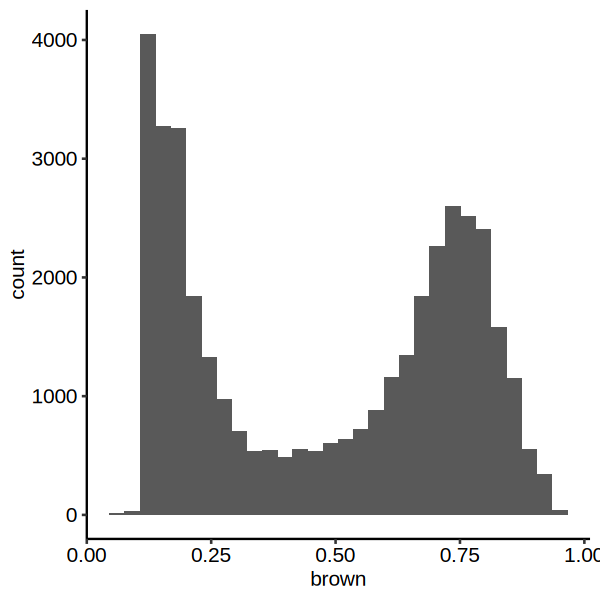

In [8]:
options(repr.plot.width = 5, repr.plot.height = 5)
df_surv_cts$brown %>% summary()
df_surv_cts %>%
    ggplot(aes(x = brown)) + geom_histogram() + theme_pubr()

In [24]:
optimal_cutoffs <- expand.grid(
  brown_threshold = seq(0.25, 0.50, by = 0.01),
  ratio_cutoff = seq(0.50, 0.90, by = 0.01)
) 
list_res = list()

for(i in c(1:nrow(optimal_cutoffs))){
  df_ratio_check <- df_surv_cts %>%
    group_by(ID) %>%
    summarize(
      ratio = mean(brown >= optimal_cutoffs$brown_threshold[i], na.rm = TRUE),
      OS        = first(OS),
      OS_CENSOR = first(OS_CENSOR),
      .groups   = "drop"
    )

  list_res[[i]] = df_ratio_check %>%
    summarise(
      n_patients = n(),
      high_ratio = sum(ratio >  optimal_cutoffs$ratio_cutoff[i]),
      event_count_high = sum(OS_CENSOR[ratio > 0.5] == 1, na.rm = TRUE),
      event_count_low = sum(OS_CENSOR[ratio <= 0.5] == 1, na.rm = TRUE)
    ) %>%
    mutate(ratio_cutoff = optimal_cutoffs$ratio_cutoff[i], brown_threshold = optimal_cutoffs$brown_threshold[i])
}

In [25]:
optimal_cutoffs = list_res %>% bind_rows() %>%
  filter(
    high_ratio >= 15 &
    high_ratio <= 58,
    event_count_high >= 20 &
    event_count_low >= 20 
  ) %>% select(ratio_cutoff, brown_threshold)

In [26]:
registerDoFuture()
plan(multisession, workers = 16)  # Adjust workers based on available cores

optimal_cutoffs %>% head()

grid_results <- foreach(i = 1:nrow(optimal_cutoffs), .combine = rbind, .packages = c("dplyr", "survival")) %dopar% {
  brown_cut <- optimal_cutoffs$brown_threshold[i]
  ratio_cut <- optimal_cutoffs$ratio_cutoff[i]
  
  df_ratio_check <- df_surv_cts %>%
    group_by(ID) %>%
    summarize(
      ratio = mean(brown > brown_cut, na.rm = TRUE),
      OS = first(OS),
      OS_CENSOR = first(OS_CENSOR),
      .groups = "drop"
    )
  
  df_ratio_check <- df_ratio_check %>%
    mutate(group = ifelse(ratio > ratio_cut, "High", "Low"))
  
  fit <- tryCatch(
    { coxph(Surv(OS, OS_CENSOR) ~ group, data = df_ratio_check) },
    error = function(e) return(NA)
  )
  
  if (inherits(fit, "coxph") && !all(is.na(coef(fit)))) {
    s <- summary(fit)
    wald_stat <- (s$coef[,"z"])^2
    pval      <- s$coef[,"Pr(>|z|)"]
  } else {
    wald_stat <- NA
    pval <- NA
  }
  
  return(data.frame(brown_cut = brown_cut, ratio_cut = ratio_cut, wald_stat = wald_stat, pval = pval))
}

best_cutoffs <- grid_results %>% arrange(desc(wald_stat)) %>% slice(1)
print(best_cutoffs)
plan(sequential)

ratio_cutoff,brown_threshold
<dbl>,<dbl>
0.5,0.29
0.5,0.30
0.5,0.31
0.5,0.32
0.5,0.33
0.5,0.34


  brown_cut ratio_cut wald_stat        pval
1      0.36      0.73  8.894374 0.002860507


In [27]:
grid_results %>% arrange(pval) %>% top_n(n = 5, -pval)

brown_cut,ratio_cut,wald_stat,pval
<dbl>,<dbl>,<dbl>,<dbl>
0.36,0.73,8.894374,0.002860507
0.37,0.73,8.894374,0.002860507
0.38,0.73,8.894374,0.002860507
0.39,0.73,8.894374,0.002860507
0.40,0.73,8.894374,0.002860507
0.41,0.73,8.894374,0.002860507
0.42,0.73,8.894374,0.002860507
0.33,0.74,8.894374,0.002860507
0.34,0.74,8.894374,0.002860507


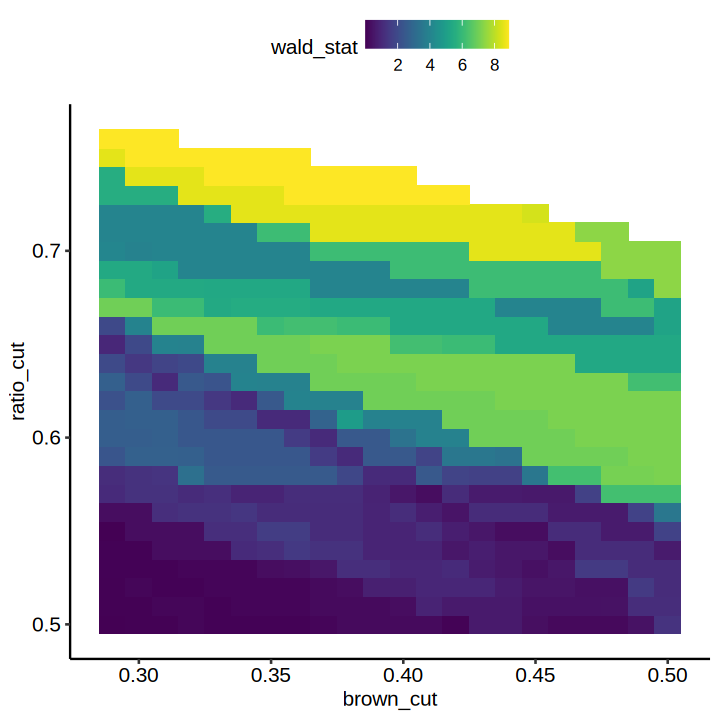

In [28]:
options(repr.plot.width = 6, repr.plot.height = 6)
grid_results %>% ggplot(aes(x = brown_cut, y = ratio_cut, fill = wald_stat)) + geom_tile() + scale_fill_viridis() + theme_pubr()
ggsave("figure_prep/p_survival_grid_search_15genes.pdf", width = 6, height = 6, dpi = 300)

In [29]:
optimal_cutoffs = list_res %>% bind_rows() %>%
  filter(
    high_ratio >= 15 &
    high_ratio <= 58,
    event_count_high >= 20 &
    event_count_low >= 20 &
    brown_threshold < 0.50 &
    ratio_cutoff > 0.6
  ) %>% select(ratio_cutoff, brown_threshold)

In [30]:

# 병렬처리 계획 설정 (전체 부트스트랩 반복에 대해 병렬화)
registerDoFuture()
plan(multisession, workers = 16)  # 사용 가능한 코어 수에 맞게 조정

# grid search에 사용할 cutoff 후보들
optimal_cutoffs %>% head()

n_boot <- 1000  # 부트스트랩 반복 횟수 (필요에 따라 조정)

boot_results <- foreach(b = 1:n_boot, .combine = rbind, 
                          .packages = c("dplyr", "survival")) %dopar% {
  # 부트스트랩 샘플 생성: df_surv_cts의 행을 재표집 (반복복원)
  boot_data <- df_surv_cts[sample(nrow(df_surv_cts), replace = TRUE), ]
  
  # 각 부트스트랩 샘플에서 grid search 수행
  grid_results <- lapply(1:nrow(optimal_cutoffs), function(i) {
    brown_cut <- optimal_cutoffs$brown_threshold[i]
    ratio_cut <- optimal_cutoffs$ratio_cutoff[i]
    
    df_ratio_check <- boot_data %>%
      group_by(ID) %>%
      summarize(
        ratio = mean(brown > brown_cut, na.rm = TRUE),
        OS = first(OS),
        OS_CENSOR = first(OS_CENSOR),
        .groups = "drop"
      )
    
    df_ratio_check <- df_ratio_check %>%
      mutate(group = ifelse(ratio > ratio_cut, "High", "Low"))
    
    fit <- tryCatch({
      coxph(Surv(OS, OS_CENSOR) ~ group, data = df_ratio_check)
    }, error = function(e) return(NA))
    
    if (inherits(fit, "coxph") && !all(is.na(coef(fit)))) {
      s <- summary(fit)
      wald_stat <- (s$coef[,"z"])^2
      pval      <- s$coef[,"Pr(>|z|)"]
    } else {
      wald_stat <- NA
      pval <- NA
    }
    
    data.frame(brown_cut = brown_cut, ratio_cut = ratio_cut, wald_stat = wald_stat, pval = pval)
  })
  
  grid_results <- do.call(rbind, grid_results)
  
  # 해당 부트스트랩 샘플에서 최적의 cutoff 선택 (Wald 통계량 기준)
  best_cutoffs <- grid_results %>% arrange(desc(wald_stat)) %>% slice(1)
  best_cutoffs$boot_iter <- b
  best_cutoffs
}

# 부트스트랩 결과 확인 (각 부트스트랩 샘플에서 선택된 최적 cutoff들)
# 병렬처리 계획 해제
plan(sequential)

ratio_cutoff,brown_threshold
<dbl>,<dbl>
0.61,0.29
0.61,0.30
0.61,0.31
0.61,0.32
0.61,0.33
0.61,0.34


Warning message:
“UNRELIABLE VALUE: One of the foreach() iterations (‘doFuture-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, use '%dorng%' from the 'doRNG' package instead of '%dopar%'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, set option 'doFuture.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: One of the foreach() iterations (‘doFuture-2’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, use '%dorng%' from the 'doRNG' package instead of '%dopar%'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, set option 'doFuture.rng.onMisuse' to "ignore".”
Wa

In [31]:
print(head(boot_results))
boot_results %>% group_by(brown_cut, ratio_cut) %>% mutate(n = n(), median_wald = median(wald_stat)) %>% arrange(-median_wald)

  brown_cut ratio_cut wald_stat        pval boot_iter
1      0.36      0.74  8.318890 0.003923488         1
2      0.47      0.65  9.778320 0.001765816         2
3      0.39      0.62  8.568760 0.003419800         3
4      0.33      0.64  9.801160 0.001744018         4
5      0.43      0.70  8.894374 0.002860507         5
6      0.48      0.67 10.654235 0.001098192         6


brown_cut,ratio_cut,wald_stat,pval,boot_iter,n,median_wald
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
0.40,0.74,12.214445,0.0004742092,42,2,12.21444
0.38,0.74,12.214445,0.0004742092,55,1,12.21444
0.40,0.74,12.214445,0.0004742092,980,2,12.21444
0.35,0.75,12.214445,0.0004742092,761,3,12.09510
0.35,0.75,9.120012,0.0025282824,839,3,12.09510
0.35,0.75,12.095104,0.0005055440,974,3,12.09510
0.38,0.68,11.885445,0.0005657431,622,1,11.88544
0.35,0.69,11.615367,0.0006540914,394,1,11.61537
0.41,0.68,11.615367,0.0006540914,855,1,11.61537


In [32]:
options(repr.plot.width = 12, repr.plot.height = 6)
p1 = boot_results %>% group_by(brown_cut, ratio_cut) %>% mutate(n = n(), median_wald = median(wald_stat)) %>%
   ggplot(aes(x = brown_cut, y = ratio_cut, fill = n)) + geom_tile() + scale_fill_viridis() + theme_pubr()
p2 = boot_results %>% group_by(brown_cut, ratio_cut) %>% mutate(n = n(), median_wald = median(wald_stat)) %>%
   ggplot(aes(x = brown_cut, y = ratio_cut, fill = median_wald)) + geom_tile() + scale_fill_viridis() + theme_pubr()

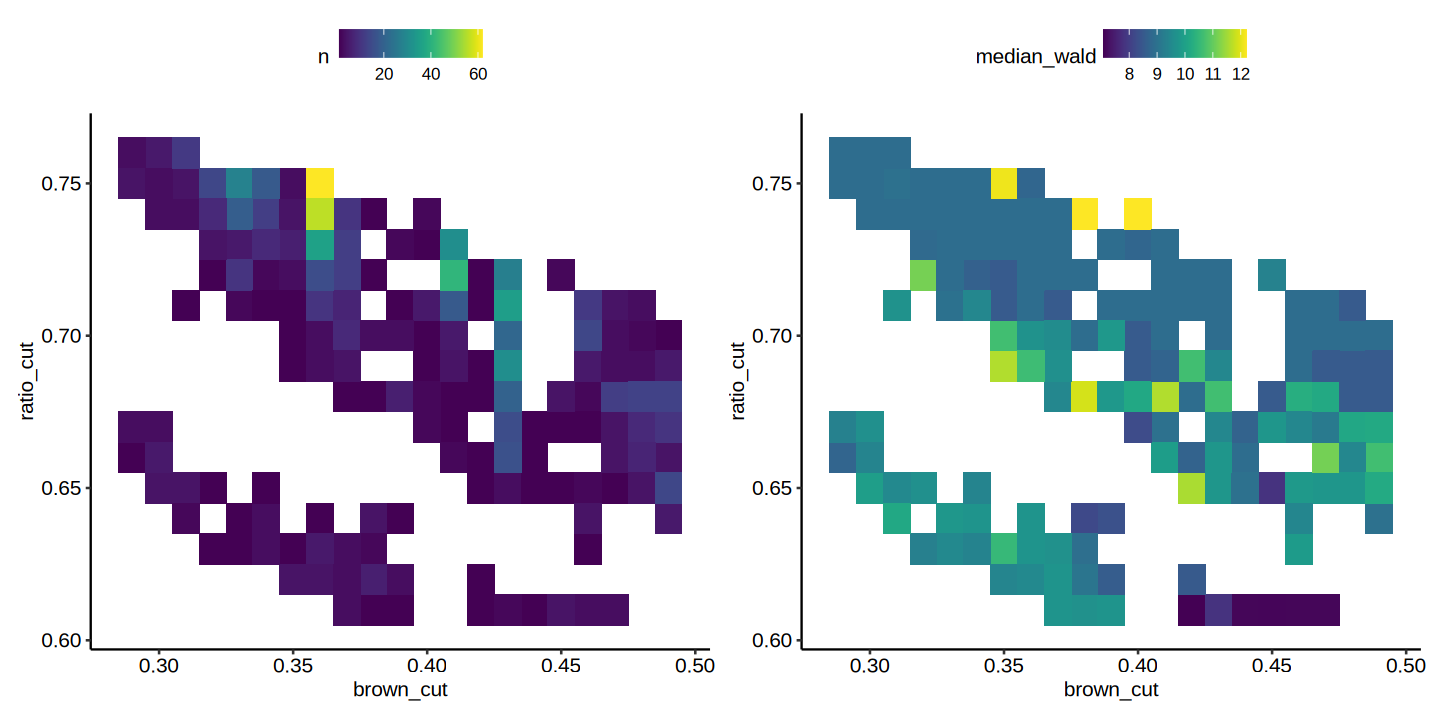

In [33]:
p1 + p2
ggsave("figure_prep/p_survival_bootstrap.pdf", width = 12, height = 6, dpi = 300)

In [9]:
# Aggregate bootstrap results
summary_results <- bootstrap_results %>%
  group_by(threshold) %>%
  summarize(
    mean_wald  = mean(wald_stat, na.rm = TRUE),
    median_p   = median(p_value, na.rm = TRUE),
    p25_p      = quantile(p_value, 0.25, na.rm = TRUE),
    p75_p      = quantile(p_value, 0.75, na.rm = TRUE),
    min_p      = min(p_value, na.rm = TRUE),
    max_p      = max(p_value, na.rm = TRUE),
    .groups    = "drop"
  )

# Find the best threshold (lowest median p-value)
best_threshold <- summary_results %>% filter(median_p == min(median_p)) %>% pull(threshold)

# Print final results
print(paste("Optimal threshold:", best_threshold))
print(summary_results)


ERROR: Error: object 'bootstrap_results' not found


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


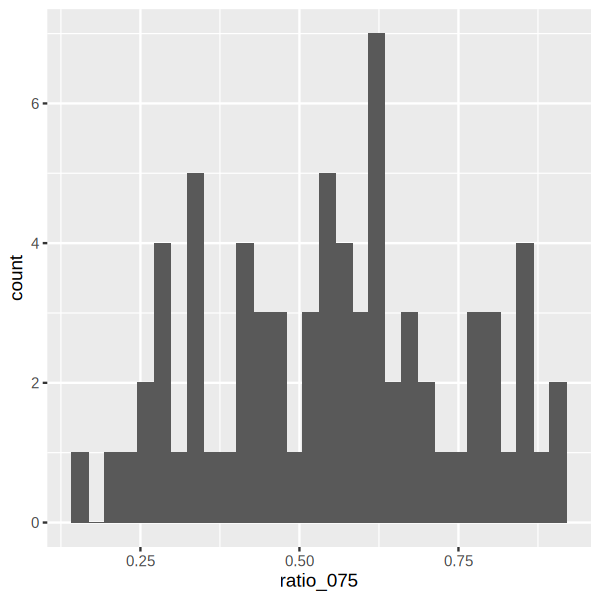

In [10]:
df_surv_cts %>%
  group_by(ID) %>%
  summarize(
    ratio_075 = mean(brown >= 0.36, na.rm = TRUE),
    OS        = first(OS),
    OS_CENSOR = first(OS_CENSOR),
    .groups   = "drop"
  ) %>%
  ggplot(aes(x = ratio_075)) + geom_histogram()

In [11]:
df_ratio_check <- df_surv_cts %>%
  group_by(ID) %>%
  summarize(
    ratio_075 = mean(brown >= 0.36, na.rm = TRUE),
    OS        = first(OS),
    OS_CENSOR = first(OS_CENSOR),
    .groups   = "drop"
  )

df_ratio_check %>%
  summarise(
    n_patients = n(),
    high_ratio_075 = sum(ratio_075 > 0.75),
    event_count_high = sum(OS_CENSOR[ratio_075 > 0.5] == 1, na.rm = TRUE),
    event_count_low = sum(OS_CENSOR[ratio_075 <= 0.5] == 1, na.rm = TRUE)
  )


n_patients,high_ratio_075,event_count_high,event_count_low
<int>,<int>,<int>,<int>
73,15,40,23


In [12]:
df_surv_ratio = df_surv_cts %>%
  group_by(ID) %>%
  summarize(
    ratio = mean(brown >= 0.36, na.rm = TRUE),
    OS        = first(OS),
    OS_CENSOR = first(OS_CENSOR),
    .groups   = "drop"
  ) %>% mutate(
    binary = factor(ifelse(ratio > 0.75, "high", "low"), levels = c("low", "high"))
  )

In [15]:
df_surv_tmp = df_surv %>% left_join(df_surv_ratio)
#df_surv = df_surv %>% dplyr::mutate(optimal_point = ifelse((CD8_TEM_ratio > cutpoint$cutpoint[[1]]), "high", "low"))

Joining with `by = join_by(ID, OS, OS_CENSOR)`


In [16]:
df_surv_tmp %>% group_by(PDL1_binary, binary) %>% summarise(n = n()) %>% pivot_wider(names_from = binary, values_from = n) %>% column_to_rownames("PDL1_binary") %>% fisher.test()

`summarise()` has grouped output by 'PDL1_binary'. You can override using the
`.groups` argument.



	Fisher's Exact Test for Count Data

data:  .
p-value = 0.7658
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3211696 4.6603166
sample estimates:
odds ratio 
  1.262464 


In [17]:
fit_os <- coxph(Surv(OS, OS_CENSOR) ~ binary + 
                                          age +
                                          PDL1_binary+regimen+
                                          Genomic_alterations+
                                          LoT + 
                                          ECOG + 
                                          sex, 
                 data = df_surv_tmp)
summary(fit_os)

Call:
coxph(formula = Surv(OS, OS_CENSOR) ~ binary + age + PDL1_binary + 
    regimen + Genomic_alterations + LoT + ECOG + sex, data = df_surv_tmp)

  n= 73, number of events= 63 

                           coef  exp(coef)   se(coef)      z Pr(>|z|)  
binaryhigh            0.7567632  2.1313662  0.3595307  2.105   0.0353 *
age                  -0.0006782  0.9993221  0.0165621 -0.041   0.9673  
PDL1_binary          -0.4955470  0.6092376  0.3584319 -1.383   0.1668  
regimenNivolumab     -1.0717366  0.3424134  0.5831291 -1.838   0.0661 .
regimenPembrolizumab -0.7979986  0.4502292  0.3808161 -2.095   0.0361 *
Genomic_alterations   0.3000373  1.3499092  0.3614494  0.830   0.4065  
LoT                   0.0602115  1.0620611  0.1062759  0.567   0.5710  
ECOG                  0.5774437  1.7814787  0.5470597  1.056   0.2912  
sex                  -0.4476685  0.6391165  0.6658467 -0.672   0.5014  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     exp(coef) 

In [18]:

fit_pfs <- coxph(Surv(PFS, PFS_CENSOR) ~ binary + 
                                          age +
                                          PDL1_binary+regimen+
                                          Genomic_alterations+
                                          LoT + 
                                          ECOG + 
                                          sex, 
                 data = df_surv_tmp)
summary(fit_pfs)

Call:
coxph(formula = Surv(PFS, PFS_CENSOR) ~ binary + age + PDL1_binary + 
    regimen + Genomic_alterations + LoT + ECOG + sex, data = df_surv_tmp)

  n= 73, number of events= 63 

                          coef exp(coef)  se(coef)      z Pr(>|z|)   
binaryhigh            0.812947  2.254542  0.343346  2.368  0.01790 * 
age                  -0.009927  0.990122  0.014942 -0.664  0.50644   
PDL1_binary          -1.010470  0.364048  0.356222 -2.837  0.00456 **
regimenNivolumab     -0.602418  0.547486  0.521155 -1.156  0.24771   
regimenPembrolizumab -0.374180  0.687853  0.356206 -1.050  0.29351   
Genomic_alterations   0.392680  1.480944  0.351564  1.117  0.26402   
LoT                  -0.139560  0.869741  0.108661 -1.284  0.19902   
ECOG                  0.550095  1.733418  0.494293  1.113  0.26575   
sex                  -0.506346  0.602694  0.616579 -0.821  0.41152   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     exp(coef) exp(-coef) lower .

In [ ]:
p1 = ggadjustedcurves(fit_os, data = as.data.frame(df_surv_tmp), variable = "binary", method = "average" ,palette = c("grey70","#C65E5A")) + 
  ggtitle("PFS, adjusted mvCOX")
p2 = ggadjustedcurves(fit_pfs, data = as.data.frame(df_surv_tmp), variable = "binary", method = "average",palette = c("grey70","#C65E5A")) + 
  ggtitle("OS, adjusted mvCOX")


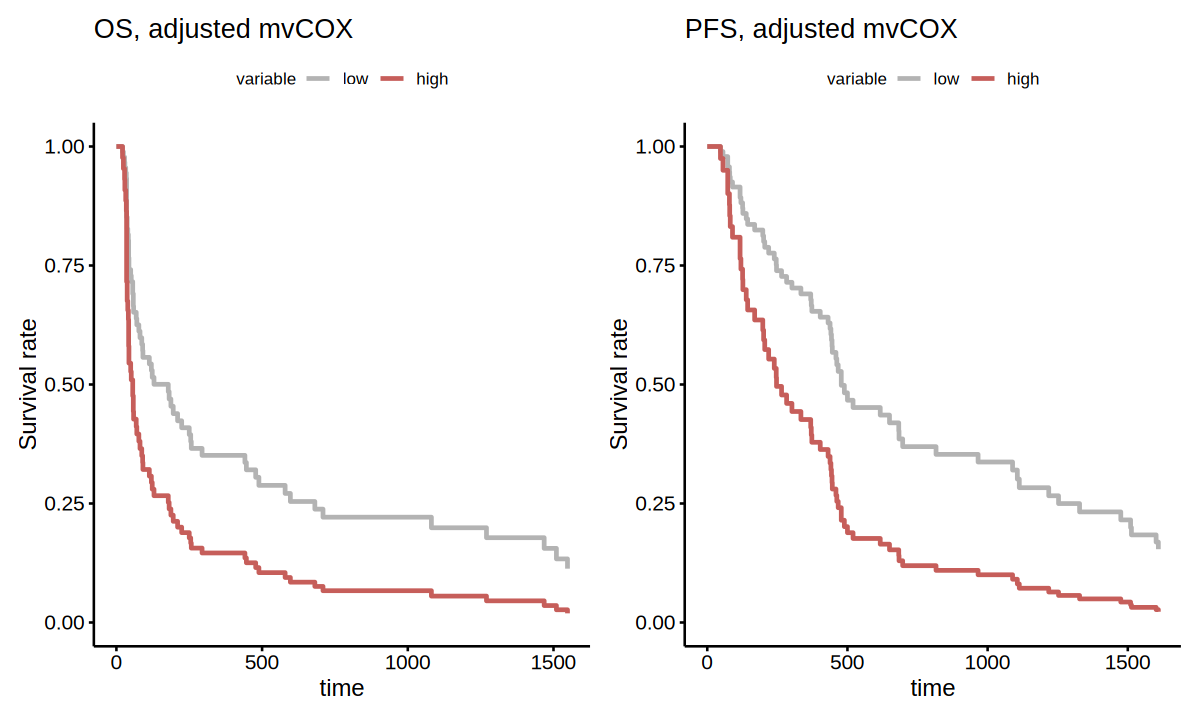

In [44]:
options(repr.plot.width = 10, repr.plot.height = 6)
p2 + p1
ggsave("figure_prep/p_survival_adjusted_cox.pdf", width = 12, height = 6, dpi = 300)

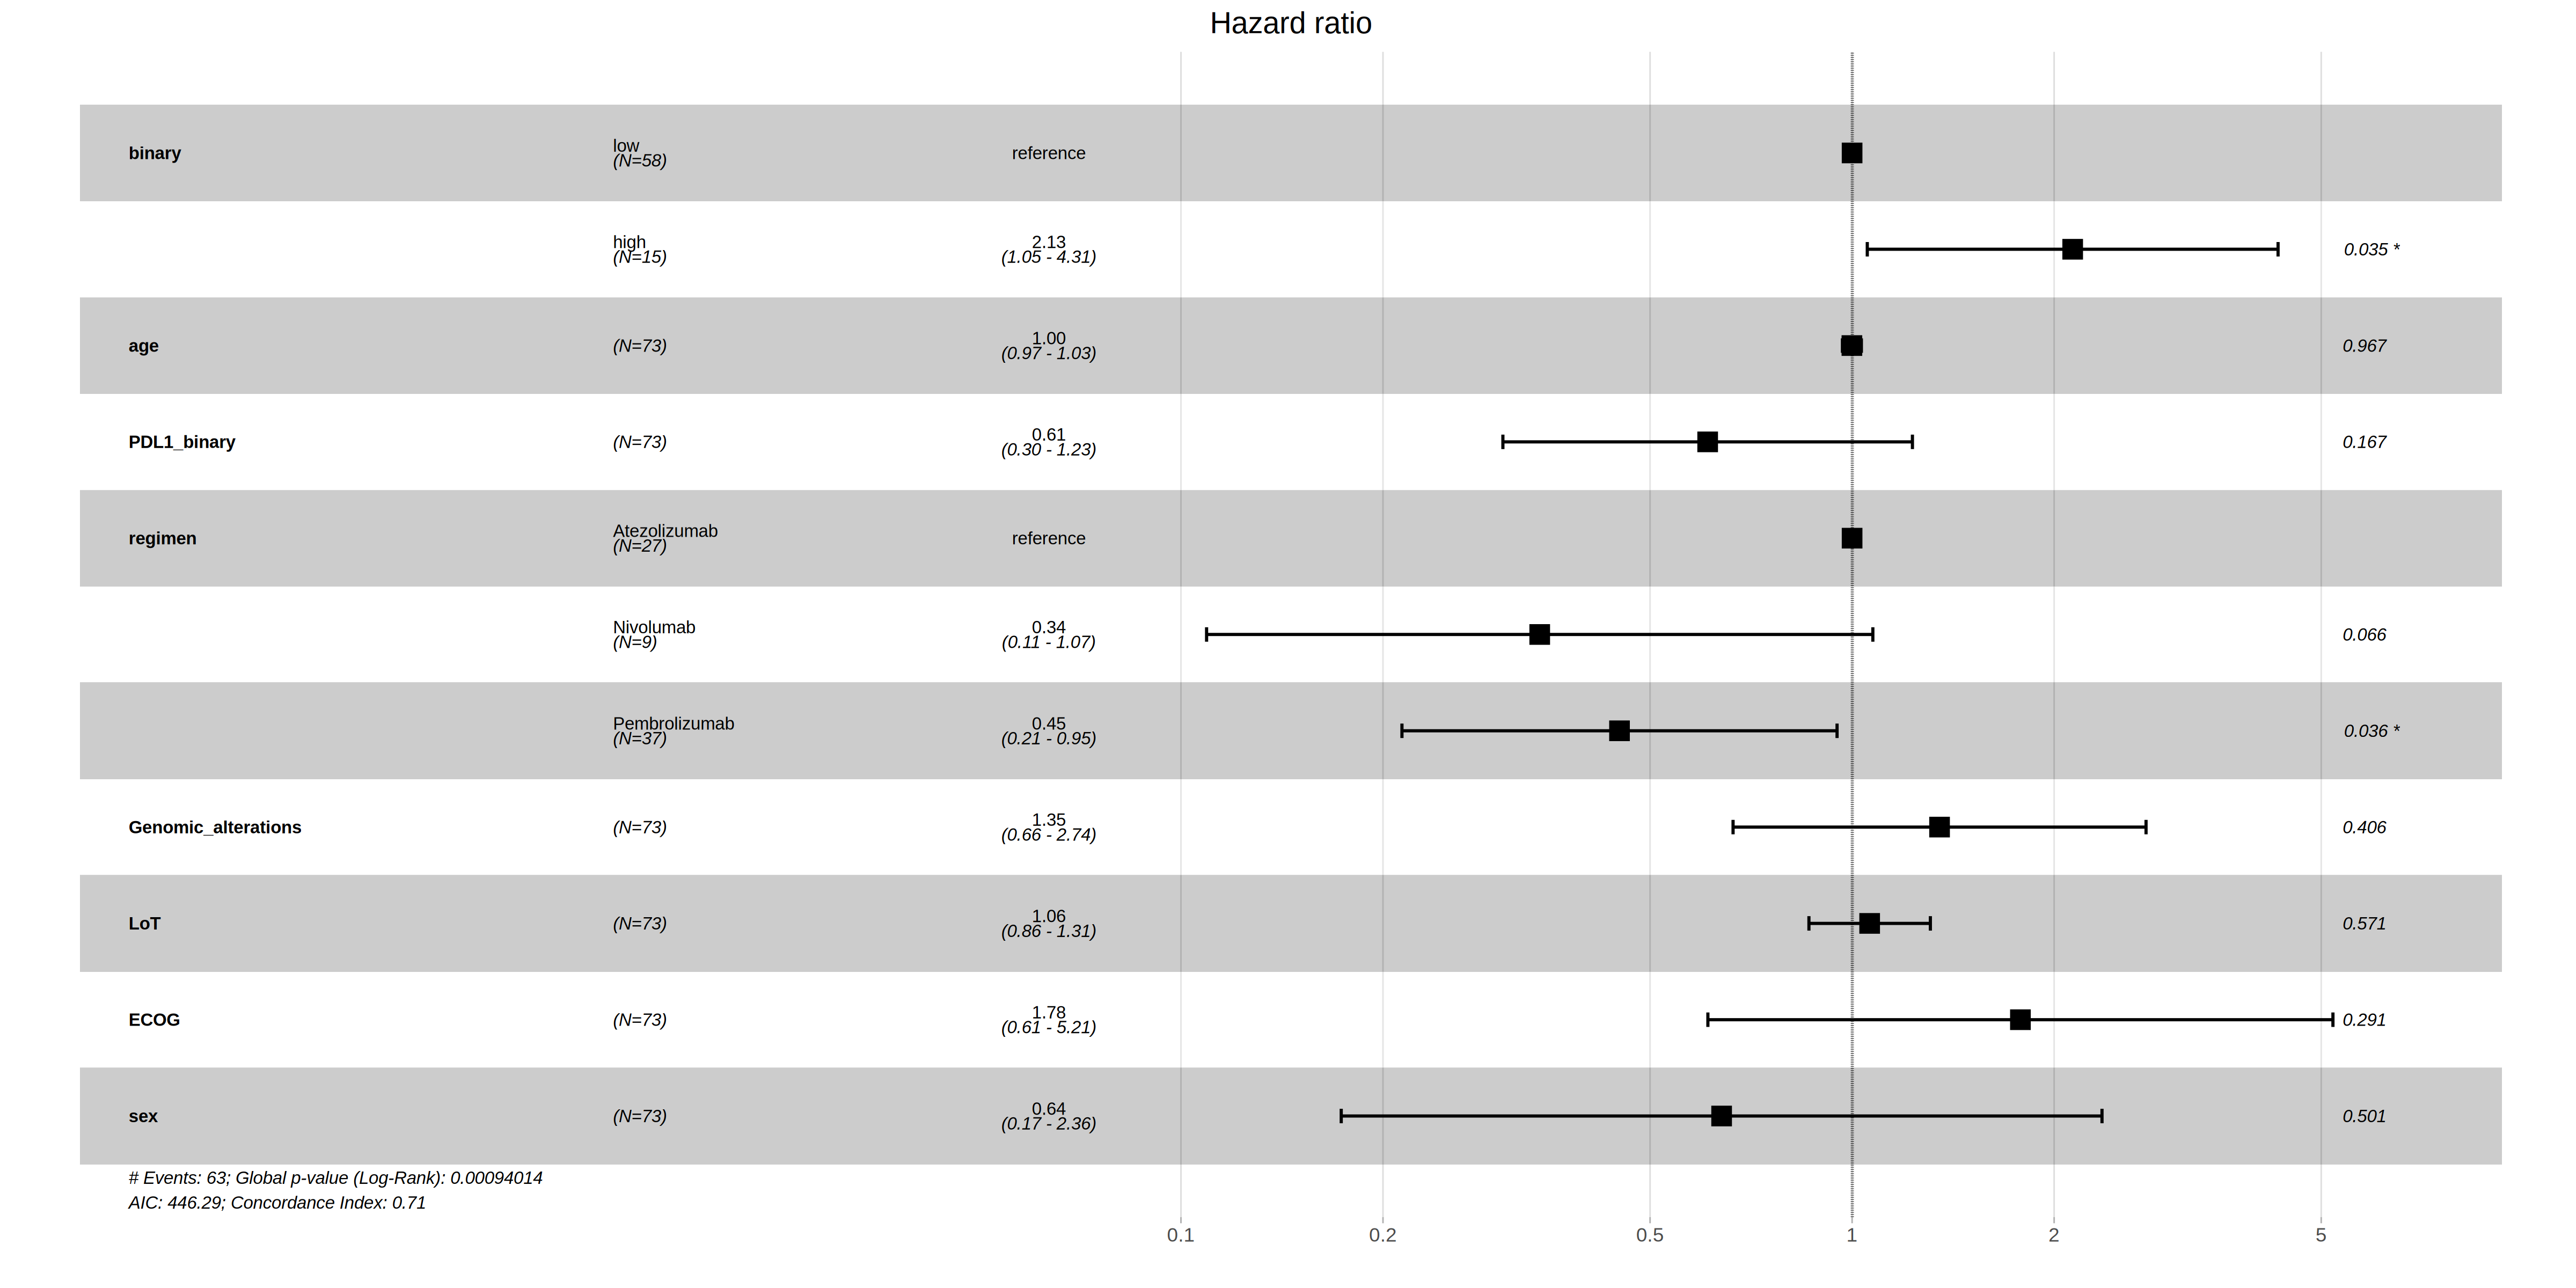

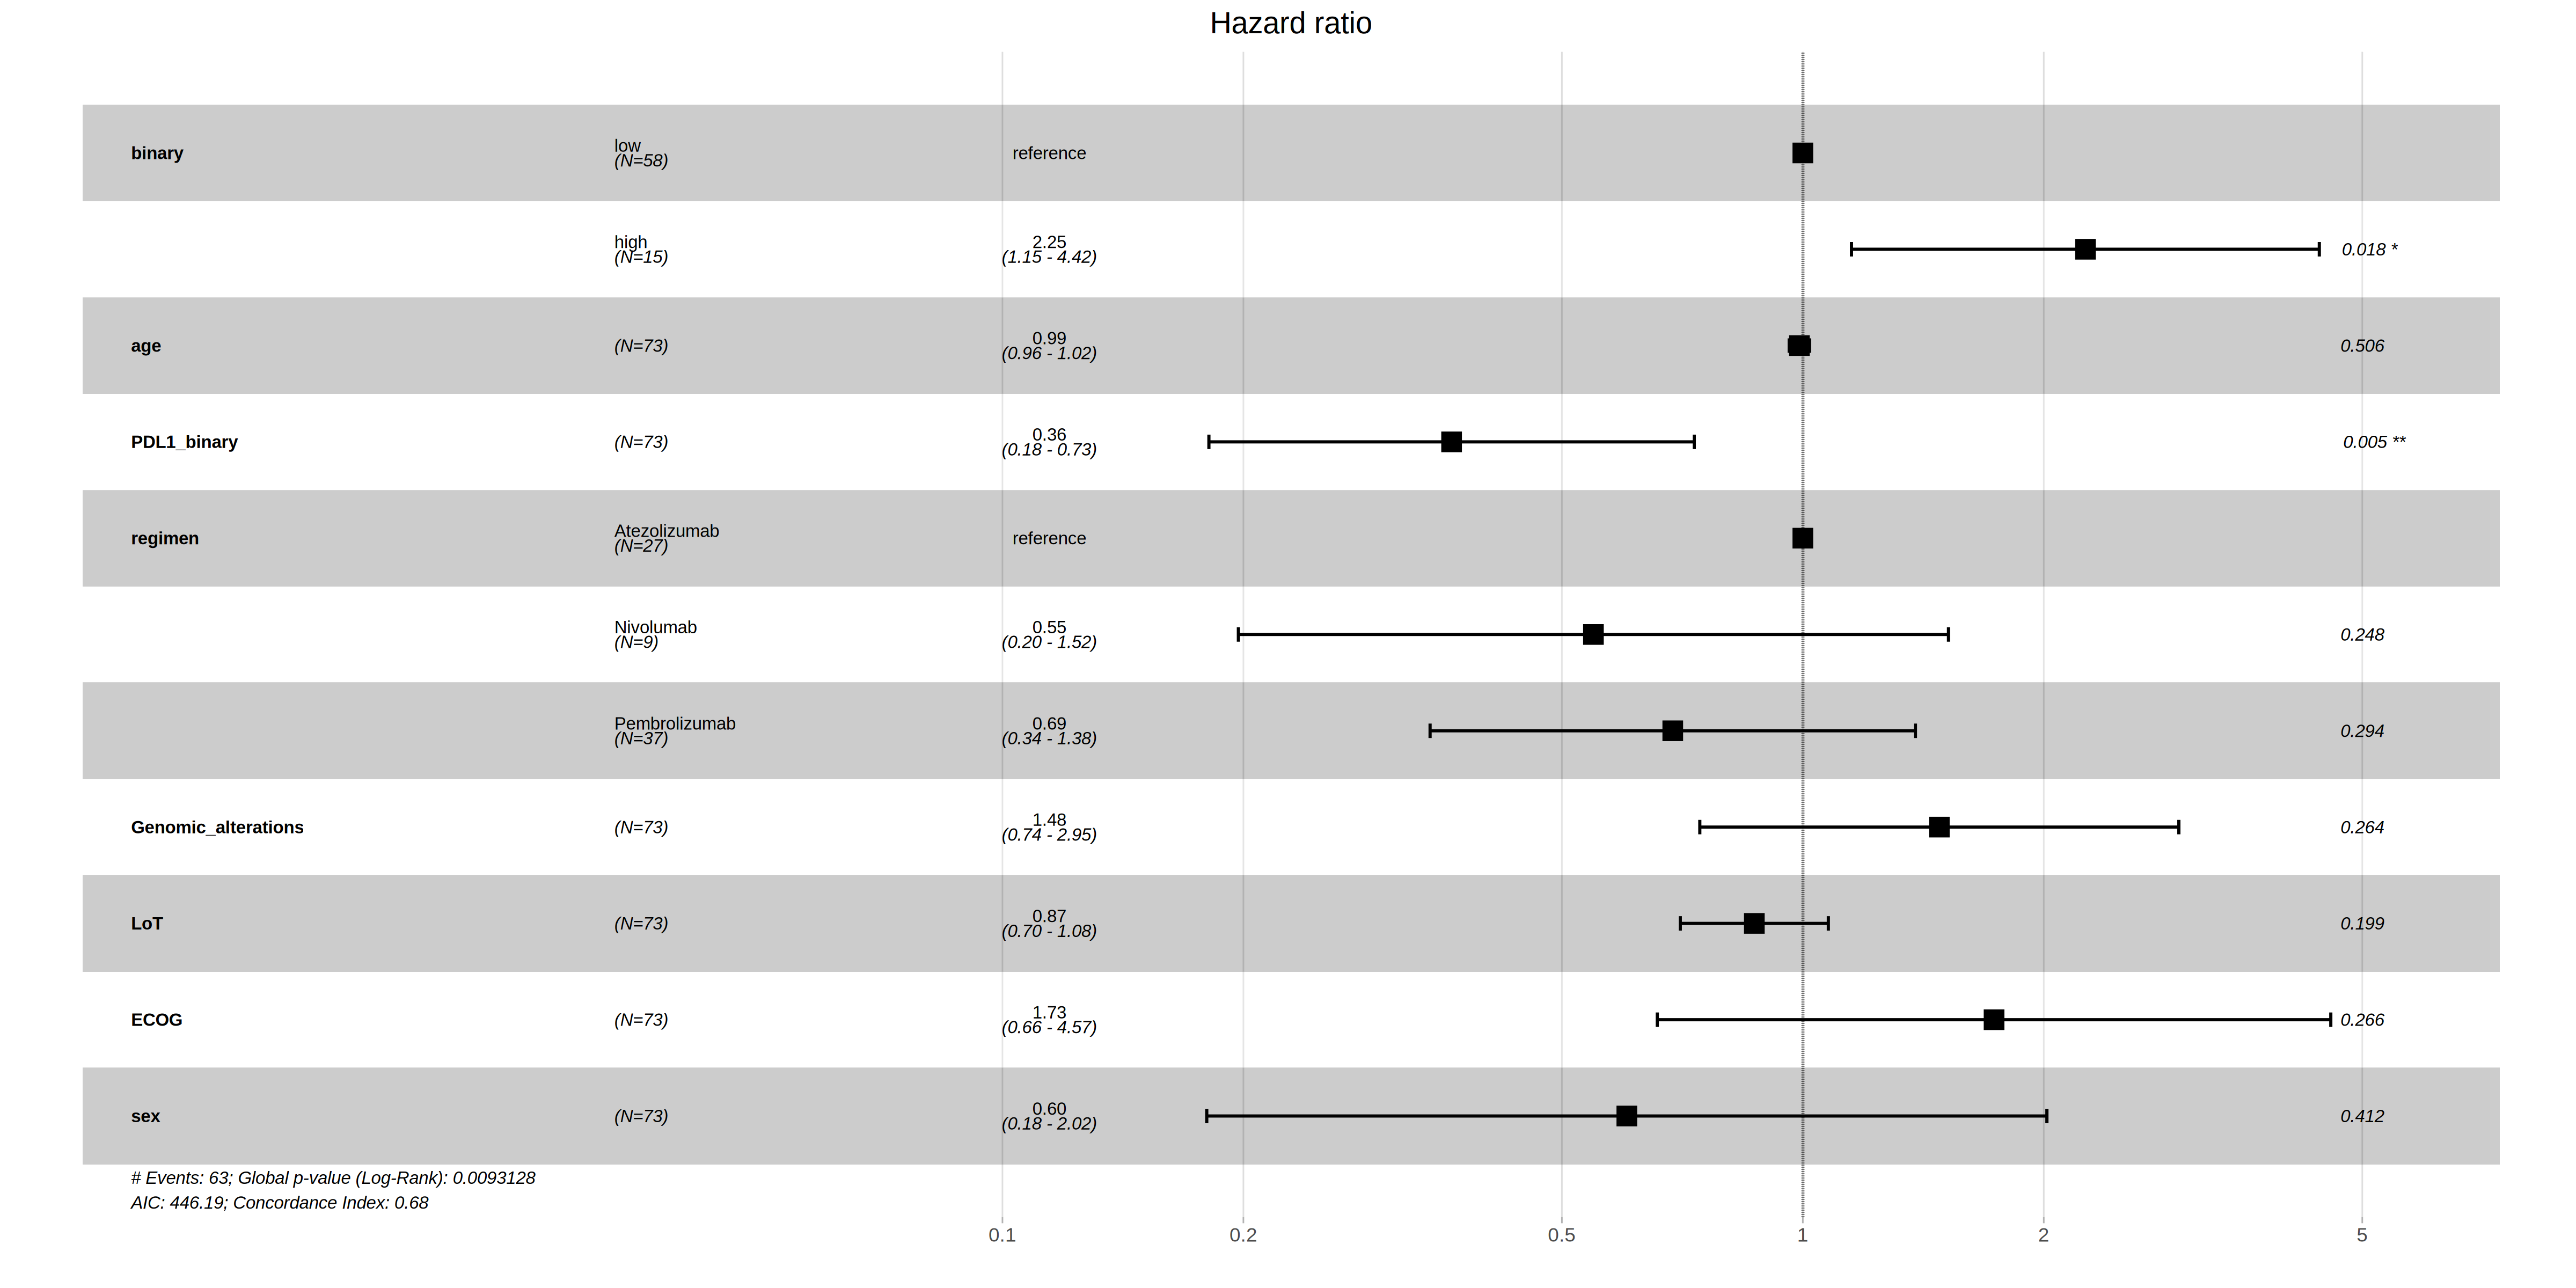

In [53]:
options(repr.plot.height = 8, repr.plot.width = 16, repr.plot.res = 300)
ggforest(fit_os, data = as.data.frame(df_surv_tmp)) & theme(text = element_text(size = 19))
#ggsave("figure_prep/p_survival_forest_os.pdf", width = 12, height = 6, dpi = 300)
ggforest(fit_pfs, data = as.data.frame(df_surv_tmp))
#ggsave("figure_prep/p_survival_forest_pfs.pdf", width = 12, height = 6, dpi = 300)

In [36]:
df_surv_dm = df_surv_tmp %>%
  mutate(PFS = round(PFS/30.417, digit=0)) 
fit = survfit(Surv(PFS, PFS_CENSOR) ~ binary, data = df_surv_dm )
print(fit)
p3 = ggsurvplot(fit,
           pval = TRUE,
           palette = c("#C65E5A", "grey70"),
           legend.labs = c("low_BMS", "high_BMS"), 
           break.x.by = 12,
           risk.table = TRUE) 
df_surv_dm = df_surv_tmp %>%
  mutate(OS = round(OS/30.417, digit=0)) 
fit = survfit(Surv(OS, OS_CENSOR) ~ binary, data = df_surv_dm )
print(fit)
p4 = ggsurvplot(fit,
           pval = TRUE,
           palette = c("#C65E5A", "grey70"),
           legend.labs = c("low_BMS","high_BMS"), 
        break.x.by = 12,
           risk.table = TRUE) 

Call: survfit(formula = Surv(PFS, PFS_CENSOR) ~ binary, data = df_surv_dm)

             n events median 0.95LCL 0.95UCL
binary=low  58     49      6       2      15
binary=high 15     14      2       1       8


Call: survfit(formula = Surv(OS, OS_CENSOR) ~ binary, data = df_surv_dm)

             n events median 0.95LCL 0.95UCL
binary=low  58     48     16      14      27
binary=high 15     15      7       4      23


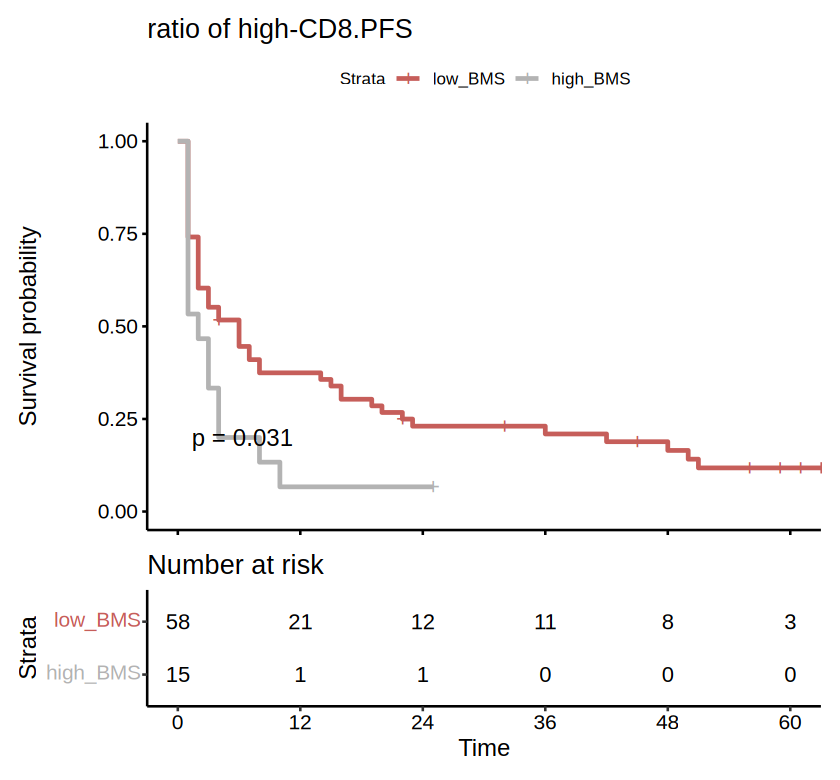

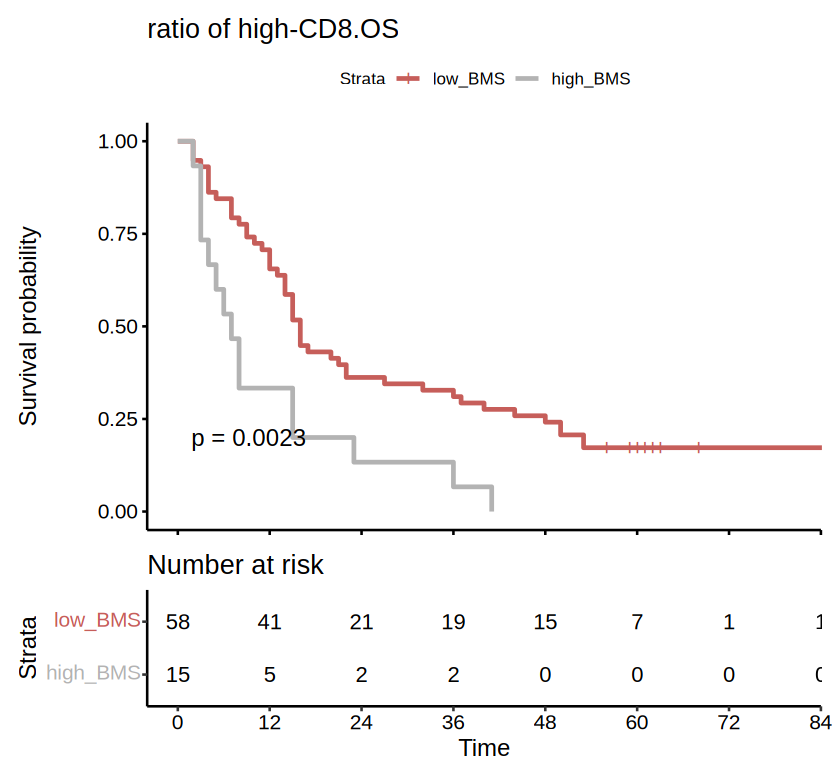

In [37]:
options(repr.plot.height = 6.5, repr.plot.width = 7)
(p3[[1]] + ggtitle("ratio of high-CD8.PFS") + theme(axis.text.x = element_blank(), axis.title.x = element_blank())) /p3[[2]] + plot_layout(heights = c(3.5,1))
ggsave("figure_prep/p_survival_curve_PFS_dm.pdf", width = 6.5, height = 7, dpi = 300)
(p4[[1]] + ggtitle("ratio of high-CD8.OS") + theme(axis.text.x = element_blank(), axis.title.x = element_blank())) /p4[[2]] + plot_layout(heights = c(3.5,1))
ggsave("figure_prep/p_survival_curve_OS_dm.pdf", width = 6.5, height = 7, dpi = 300)